<a href="https://colab.research.google.com/github/sajadalipour7/Persian-Grapheme-To-Phoneme-With-Transformer/blob/main/PersianG2P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [4]:
import pandas as pd
data=pd.read_csv("data.csv",encoding="utf-8")

In [5]:
print(len(data))
data.head(30)

75182


,grapheme,phoneme
0,ره,rahmatollAh'alayh
1,ره,rahmatollAh
2,ص,salavAtollAh'alayh
3,ع,'alayhessalAm
4,عج,'ajalallAhota'AlA
5,ق.ا.,qanune'asAsi
6,ق.م.,qanunemadani
7,ق.م.,qablazmilAd
8,ق.م,qablazmilAd
9,ق‌م,qablazmilAd


## Deleting 0 to 19 rows:
because they are abbreviations in persian

In [6]:
data=data.drop(data.index[:20])
print(len(data))
data.head(30)

75162


,grapheme,phoneme
20,اب,'ab
21,ابا,'ebA
22,ابا,'abA
23,اباء,ebA'
24,اباالفضل‌العباس,abalfazle'abbAs
25,ابابکر,'abAbakr
26,ابابیل,'abAbil
27,اباجعفر,'abAja'far
28,اباحتی,'ebAhati
29,اباحه,'ebAhe


## Splitting data to train,validation,test

In [7]:
graphemes=list(data["grapheme"])
phonemes=list(data["phoneme"])
len(graphemes),len(phonemes)

(75162, 75162)

In [8]:
all_data=[]
for i in range(len(graphemes)):
  all_data.append((graphemes[i],phonemes[i]))

In [9]:
len(all_data),all_data[70000]

(75162, ('نگاشتن', 'negAStan'))

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_iter,test_iter=train_test_split(all_data,test_size=0.2,random_state=42,shuffle=True)

In [12]:
len(train_iter),len(test_iter)

(60129, 15033)

# Tokenizer:
Since both graphemes and phonemes have no space character we just list the string for tokenizer

In [13]:
def my_tokenizer(word : str):
  return list(word)

# Building vocab and token transform

In [14]:
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

token_transform = {}
vocab_transform = {}

SRC_LANGUAGE = 'grapheme'
TGT_LANGUAGE = 'phoneme'

token_transform[SRC_LANGUAGE] = my_tokenizer
token_transform[TGT_LANGUAGE] = my_tokenizer

# yield token for build_vocab_from_iterator function
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

#special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    all_iter=all_data
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(all_data, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Creating Transformer Model

In [15]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## PositionalEncoding

In [16]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


## TokenEmbedding

In [17]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


## Seq2Seq Transformer model

In [18]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

# Masking mechanism
During training, we need a subsequent character mask that will prevent model to look into the future characters when making predictions. We will also need masks to hide source and target padding tokens. Below, let’s define a function that will take care of both.

Reference : https://pytorch.org/tutorials/beginner/translation_transformer.html

In [19]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# Building Model

In [21]:
torch.manual_seed(42)

# Hyperparameters
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 5
NUM_DECODER_LAYERS = 5

# Instantiating Model
g2p_model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

# weights and biases initialization
for p in g2p_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

g2p_model = g2p_model.to(DEVICE)

# CrossEntropy Loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Adam optimizer
optimizer = torch.optim.Adam(g2p_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Collation
our data iterator yields a pair of raw strings. We need to convert these string pairs into the batched tensors that can be processed by our Seq2Seq network defined previously. Below we define our collate function that convert batch of raw strings into batch tensors that can be fed directly into our model.

Reference : https://pytorch.org/tutorials/beginner/translation_transformer.html

In [22]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

# Training

In [23]:
from torch.utils.data import DataLoader

## Training function

In [24]:
def train_function(model, optimizer):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(train_dataloader)

## Evaluating function

In [25]:
def evaluate_function(model):
    model.eval()
    losses = 0

    val_iter=test_iter
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

## Train model for N epochs

In [26]:
from timeit import default_timer as timer
NUM_EPOCHS = 20

stats_for_plotting={"train_losses":[],"test_losses":[]}
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_function(g2p_model, optimizer)
    end_time = timer()
    val_loss = evaluate_function(g2p_model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    stats_for_plotting["train_losses"].append(train_loss)
    stats_for_plotting["test_losses"].append(val_loss)
    torch.save(g2p_model.state_dict(),f"./G2P/epoch_{epoch}.pth")

Epoch: 1, Train loss: 1.433, Val loss: 0.644, Epoch time = 52.701s
Epoch: 2, Train loss: 0.557, Val loss: 0.330, Epoch time = 51.212s
Epoch: 3, Train loss: 0.366, Val loss: 0.259, Epoch time = 53.043s
Epoch: 4, Train loss: 0.303, Val loss: 0.233, Epoch time = 52.922s
Epoch: 5, Train loss: 0.266, Val loss: 0.224, Epoch time = 53.390s
Epoch: 6, Train loss: 0.241, Val loss: 0.203, Epoch time = 53.591s
Epoch: 7, Train loss: 0.220, Val loss: 0.189, Epoch time = 53.762s
Epoch: 8, Train loss: 0.205, Val loss: 0.182, Epoch time = 53.812s
Epoch: 9, Train loss: 0.191, Val loss: 0.173, Epoch time = 53.910s
Epoch: 10, Train loss: 0.179, Val loss: 0.165, Epoch time = 53.947s
Epoch: 11, Train loss: 0.170, Val loss: 0.161, Epoch time = 53.964s
Epoch: 12, Train loss: 0.160, Val loss: 0.155, Epoch time = 53.987s
Epoch: 13, Train loss: 0.153, Val loss: 0.153, Epoch time = 53.979s
Epoch: 14, Train loss: 0.145, Val loss: 0.147, Epoch time = 54.013s
Epoch: 15, Train loss: 0.139, Val loss: 0.144, Epoch time

In [27]:
for param_group in optimizer.param_groups:
        param_group['lr'] = lr=0.00005

In [28]:
for epoch in range(21, NUM_EPOCHS+10):
    start_time = timer()
    train_loss = train_function(g2p_model, optimizer)
    end_time = timer()
    val_loss = evaluate_function(g2p_model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    stats_for_plotting["train_losses"].append(train_loss)
    stats_for_plotting["test_losses"].append(val_loss)
    torch.save(g2p_model.state_dict(),f"./G2P/epoch_{epoch}.pth")

Epoch: 21, Train loss: 0.097, Val loss: 0.129, Epoch time = 51.935s
Epoch: 22, Train loss: 0.091, Val loss: 0.128, Epoch time = 52.588s
Epoch: 23, Train loss: 0.087, Val loss: 0.129, Epoch time = 53.207s
Epoch: 24, Train loss: 0.083, Val loss: 0.129, Epoch time = 53.571s
Epoch: 25, Train loss: 0.081, Val loss: 0.128, Epoch time = 53.811s
Epoch: 26, Train loss: 0.078, Val loss: 0.129, Epoch time = 54.012s
Epoch: 27, Train loss: 0.076, Val loss: 0.131, Epoch time = 54.278s
Epoch: 28, Train loss: 0.074, Val loss: 0.129, Epoch time = 54.248s
Epoch: 29, Train loss: 0.072, Val loss: 0.131, Epoch time = 54.338s


In [30]:
for param_group in optimizer.param_groups:
        param_group['lr'] = lr=0.00001

In [31]:
for epoch in range(30, 32):
    start_time = timer()
    train_loss = train_function(g2p_model, optimizer)
    end_time = timer()
    val_loss = evaluate_function(g2p_model)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    stats_for_plotting["train_losses"].append(train_loss)
    stats_for_plotting["test_losses"].append(val_loss)
    torch.save(g2p_model.state_dict(),f"./G2P/epoch_{epoch}.pth")

Epoch: 30, Train loss: 0.064, Val loss: 0.130, Epoch time = 52.731s
Epoch: 31, Train loss: 0.060, Val loss: 0.130, Epoch time = 55.893s


## Plotting stats

In [32]:
from matplotlib import pyplot as plt

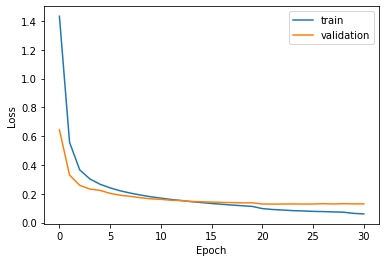

In [33]:
plt.plot(stats_for_plotting["train_losses"],label="train")
plt.plot(stats_for_plotting["test_losses"],label="validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [34]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 37.0 MB/s 
     |████████████████████████████████| 2.0 MB 64.8 MB/s 
     |████████████████████████████████| 104 kB 78.3 MB/s 


# Inference

## decoder function
it is called greedy decoder because we don't do any beam search for results

In [35]:
# function to generate output sequence
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


## Inference function
gives a grapheme and outputs the phoneme

In [36]:
def inference(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

# Evaluating model last checkpoint

## 1.Saving all predictions

In [37]:
from tqdm import tqdm
all_preds=[]
for gs,ps in tqdm(test_iter):
  ground_truth=ps
  myoutput=inference(g2p_model,gs)
  all_preds.append(myoutput.replace(" ",""))

100%|██████████| 15033/15033 [17:07<00:00, 14.64it/s]


## 2.Calculating WER and PER
WER : Word error rate

PER : Phoneme error rate

In [39]:
from jiwer import cer,wer

In [40]:
trues=0
all_num=0
average_cer=0
average_wer=0
for i in range(len(all_preds)):
  if all_preds[i]==test_iter[i][1]:
    trues+=1
  all_num+=1
  average_cer+=cer(test_iter[i][1],all_preds[i])
  average_wer+=wer(test_iter[i][1],all_preds[i])
average_cer/=len(all_preds)
average_wer/=len(all_preds)
exact_accuracy=trues/all_num
print(f"Exact Accuracy : {exact_accuracy}")
print(f"PER : {average_cer}")
print(f"WER : {average_wer}")

Exact Accuracy : 0.7321891837956496
PER : 0.0625098467636139
WER : 0.26781081620435043


## Some examples:




In [44]:
some_example_df=pd.DataFrame(columns=['Grapheme','Predicted Phoneme','Correct Phoneme'])

In [49]:
import random
some_examples=random.sample(test_iter, 20)
example_gs=[]
example_gt_phonemes=[]
example_pred_phonemes=[]
for example in some_examples:
  example_gs.append(example[0])
  example_gt_phonemes.append(example[1])
  example_pred_phonemes.append(inference(g2p_model,example[0]).replace(" ",""))
some_example_df["Grapheme"]=example_gs
some_example_df["Predicted Phoneme"]=example_pred_phonemes
some_example_df["Correct Phoneme"]=example_gt_phonemes
some_example_df

,Grapheme,Predicted Phoneme,Correct Phoneme
0,کدونیمه,kadunime,kadunime
1,لاقیدی,lAqeydi,lAqeydi
2,حصر,hasr,hasar
3,اتاقه,'otAqe,'otAqe
4,آزرمگین,'Azarmgin,'Azarmgin
5,رفیعی‌پور,rafi'ipur,rafi'ipur
6,پسیانی,pesyAni,pesyAni
7,وخیم,vaxim,vaxim
8,دیان,diyAn,dayyAn
9,دگرریختی,degarrixti,degarrixti
